# 🛠 06. Transfer Learning in TensorFlow Part 3: Scaling-up Exercise Solutions
1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?

2. Recreate the first model (the feature extraction model) with mixed_precision turned on.

  * Does it make the model train faster?
  * Does it effect the accuracy or performance of our model?
  * What's the advatanges of using mixed_precision training?
3. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁 .

## Getting data and helper function

In [ ]:
# Getting the helper functions 
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


--2021-09-19 15:35:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-19 15:35:20 (37.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]

--2021-09-19 15:35:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

In [ ]:
# Walk through the data
walk_through_dir("101_food_classes_10_percent")

# 🛠 Exercises
1. Use the same evaluation techniques on the large-scale Food Vision model as you did in the previous notebook (Transfer Learning Part 3: Scaling up). More specifically, it would be good to see:
* A confusion matrix between all of the model's predictions and true labels.
* A graph showing the f1-scores of each class.
* A visualization of the model making predictions on various images and comparing the predictions to the ground truth.
    * For example, plot a sample image from the test dataset and have the title of the plot show the prediction, the prediction probability and the ground truth label.
2. Take 3 of your own photos of food and use the Food Vision model to make predictions on them. How does it go? Share your images/predictions with the other students.
3. Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?
4. Name one important benefit of mixed precision training, how does this benefit take place?

## Preparing Data !

In [ ]:
# Import required module
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [ ]:
# Setup input
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Create checkpoint callback to save model
checkpoint_path = "101_food_classes_10_percent/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         verbose=0)

In [ ]:
# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255)                                
])

In [ ]:
# # Set global policy to our model
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy(policy="mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
class_names = train_data.class_names

In [ ]:
# setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup architecture of model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name='pooling_layer')(x)
# x = layers.Dense(len(class_names))(x)

# Seperate outputs activation
# outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name='output_layer')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model_aug_mixed = tf.keras.Model(inputs, outputs, name="model_mixed_policy_data_augmentation")

# Check model architecture
model_aug_mixed.summary()

Model: "model_mixed_policy_data_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compiling the model
model_aug_mixed.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [ ]:
# Fit model for 5 epochs
initial_epochs = 5

history_model_0 = model_aug_mixed.fit(train_data,
                                      epochs=initial_epochs,
                                      validation_data= test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 166s 488ms/step - loss: 3.4689 - accuracy: 0.2465 - val_loss: 2.6246 - val_accuracy: 0.4070
Epoch 2/5
237/237 [==============================] - 116s 488ms/step - loss: 2.3375 - accuracy: 0.4605 - val_loss: 2.2091 - val_accuracy: 0.4619
Epoch 3/5
237/237 [==============================] - 104s 436ms/step - loss: 1.9682 - accuracy: 0.5332 - val_loss: 2.0203 - val_accuracy: 0.4992
Epoch 4/5
237/237 [==============================] - 92s 386ms/step - loss: 1.7528 - accuracy: 0.5783 - val_loss: 1.9885 - val_accuracy: 0.4913
Epoch 5/5
237/237 [==============================] - 84s 355ms/step - loss: 1.6028 - accuracy: 0.6045 - val_loss: 1.9061 - val_accuracy: 0.5058


In [ ]:
# Evaluate our model on test data
model_aug_mixed.evaluate(test_data)

 30/790 [>.............................] - ETA: 1:20 - loss: 2.0290 - accuracy: 0.4854

KeyboardInterrupt: ignored

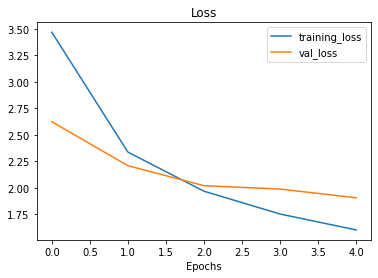

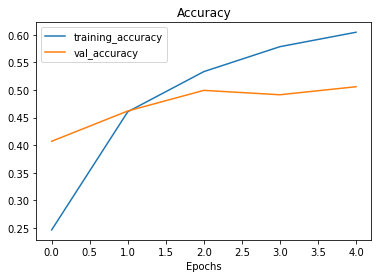

In [ ]:
# Plot loss curves
plot_loss_curves(history_model_0)

## Fine-tuning our model

In [ ]:
# Freeze all layers except last 5 
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Check which layer is unfreeze
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

In [ ]:
# Recompilng the model
model_aug_mixed.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(0.001 / 10),
                        metrics=["accuracy"])

model_aug_mixed.summary()

Model: "model_mixed_policy_data_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 910,821
Non-trainable params: 3,268,131
_________________________________________________________________


In [ ]:
# Fine tune for more 5 epochs
fine_tune_epochs = initial_epochs + 5 
history_model_1 = model_aug_mixed.fit(train_data,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      initial_epoch=history_model_0.epoch[-1])

Epoch 5/10
237/237 [==============================] - 94s 363ms/step - loss: 1.3712 - accuracy: 0.6426 - val_loss: 1.8758 - val_accuracy: 0.5098
Epoch 6/10
237/237 [==============================] - 84s 354ms/step - loss: 1.2427 - accuracy: 0.6706 - val_loss: 1.8788 - val_accuracy: 0.5111
Epoch 7/10
237/237 [==============================] - 73s 307ms/step - loss: 1.1592 - accuracy: 0.6907 - val_loss: 1.8851 - val_accuracy: 0.5140
Epoch 8/10
237/237 [==============================] - 77s 324ms/step - loss: 1.0838 - accuracy: 0.7109 - val_loss: 1.8978 - val_accuracy: 0.5066
Epoch 9/10
237/237 [==============================] - 73s 305ms/step - loss: 1.0390 - accuracy: 0.7244 - val_loss: 1.8690 - val_accuracy: 0.5127
Epoch 10/10
237/237 [==============================] - 65s 275ms/step - loss: 0.9580 - accuracy: 0.7460 - val_loss: 1.8651 - val_accuracy: 0.5140


In [ ]:
# Evaluate the fine_tune_model
results = model_aug_mixed.evaluate(test_data)

790/790 [==============================] - 82s 103ms/step - loss: 1.6056 - accuracy: 0.5793


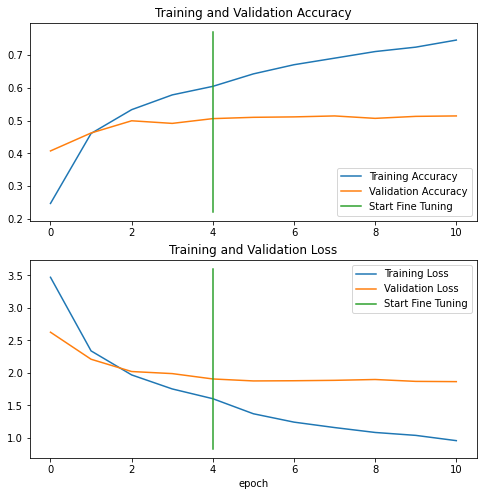

In [ ]:
# plot compare historys
compare_historys(original_history=history_model_0,
                 new_history=history_model_1,
                 initial_epochs=5)

## Make predictions 

In [ ]:
# Make predictions with model
pred_probs = model_aug_mixed.predict(test_data, verbose=1)

790/790 [==============================] - 75s 93ms/step


In [ ]:
len(pred_probs)

25250

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
pred_probs[:10]

array([[5.898e-01, 9.644e-05, 1.479e-01, ..., 9.948e-05, 7.768e-04,
        5.319e-02],
       [9.307e-01, 1.788e-07, 2.480e-03, ..., 5.066e-03, 4.768e-07,
        5.901e-06],
       [4.185e-01, 2.592e-03, 1.092e-02, ..., 7.544e-04, 1.187e-03,
        1.687e-03],
       ...,
       [2.498e-01, 2.742e-06, 3.386e-03, ..., 8.417e-02, 6.642e-04,
        4.792e-05],
       [1.826e-01, 7.377e-04, 1.131e-01, ..., 7.348e-04, 1.494e-04,
        5.860e-04],
       [5.347e-01, 1.431e-06, 5.732e-04, ..., 1.502e-02, 3.695e-06,
        4.944e-03]], dtype=float16)

In [ ]:
# Get the class predictions
pred_class = pred_probs.argmax(axis=1)
pred_class[:10]

array([ 0,  0,  0,  8, 29, 78, 29,  0,  9,  0])

In [ ]:
# Unbatch test data and get image label
y_label = []
for image, label in test_data.unbatch(): # unbatch test data and get image, label
  y_label.append(label.numpy().argmax())
y_label[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
type(label)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
len(y_label)

25250

## Evaluating our models predictions


In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_label, pred_class)
sklearn_accuracy

0.5793267326732673

In [ ]:
# Does the evaluate method equal accuracy_score?
import numpy as np
print(f"Close?: {np.isclose(results, sklearn_accuracy)} | Difference: {results-sklearn_accuracy} ")

Close?: [False  True] | Difference: [1.02626886e+00 1.61746941e-08] 


In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
make_confusion_matrix(y_label, pred_class, classes=class_names, figsize=(100,100), text_size=20)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_label, pred_class))

In [ ]:
# Get a dictionary of classification report
classification_report_dic = classification_report(y_label, pred_class, output_dict=True)
classification_report_dic

In [ ]:
# Create empty dictionary
class_f1_scores = {}

for k, v in classification_report_dic.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

In [ ]:
import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1_score": list(class_f1_scores.values())}).sort_values("f1_score", ascending=False)
f1_scores.head()                          

,class_names,f1_score
33,edamame,0.962525
63,macarons,0.855876
45,frozen_yogurt,0.823529
86,sashimi,0.822857
54,hot_and_sour_soup,0.818004


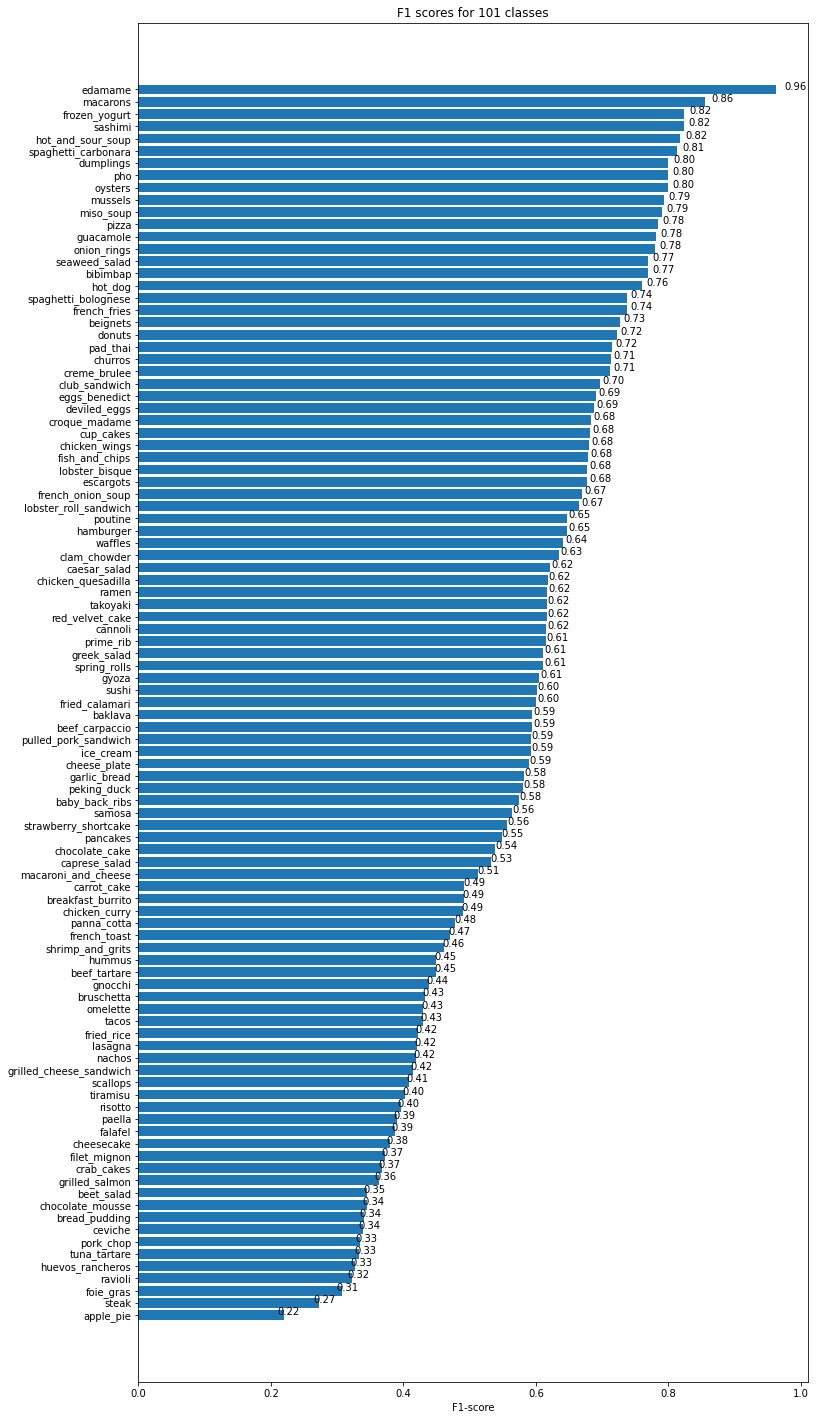

In [ ]:
# Plot dictionary on bar plot

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1_score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("F1-score")
ax.set_title("F1 scores for 101 classes")
ax.invert_yaxis();

def auto_label(rects):
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

auto_label(scores)

## Visualizing predictions on test images


In [ ]:
# define fuction to load and pred

def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read the img
  img = tf.io.read_file(filename)
  # Decode into a tensor
  img = tf.io.decode_image(img)
  # Resize a img
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    return img/255.
  else:
    return img

In [ ]:
class_names = train_data.class_names

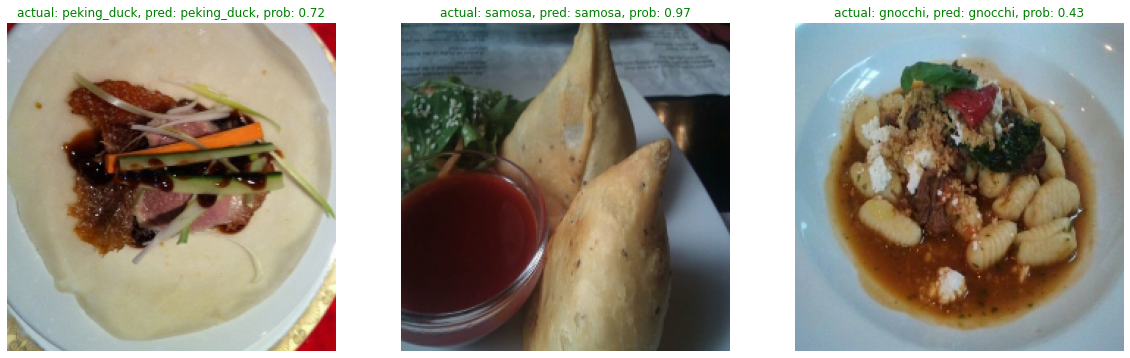

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20,7))
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" +class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_probs = model_aug_mixed.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_probs.argmax()]

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color="g"
  else:
    title_color="r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_probs.max():.2f}", c=title_color)
  plt.axis(False);

# Retrain the model (feature extraction and fine-tuning) we trained in this notebook, except this time use EfficientNetB4 as the base model instead of EfficientNetB0. Do you notice an improvement in performance? Does it take longer to train? Are there any tradeoffs to consider?

In [ ]:
class_names= train_data.class_names

In [ ]:
# Set up base model
base_model_B4 = tf.keras.applications.EfficientNetB4(include_top=False)
base_model_B4.trainable = False

# Set up architecture of model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model_B4(x, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)

outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

# Combine inputs , output to ur model
model_B4 = tf.keras.Model(inputs, outputs, name="Model_B4")

# Compiling the model
model_B4.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [ ]:
model_B4.summary()

Model: "Model_B4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1792)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               181093    
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
history_model_B4 = model_B4.fit(train_data,
                                epochs=5,
                                validation_data = test_data,
                                validation_steps = int(0.15*len(test_data)),
                                callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 299s 1s/step - loss: 3.4179 - accuracy: 0.2531 - val_loss: 2.5718 - val_accuracy: 0.4052
Epoch 2/5
237/237 [==============================] - 205s 860ms/step - loss: 2.3591 - accuracy: 0.4411 - val_loss: 2.1132 - val_accuracy: 0.4799
Epoch 3/5
237/237 [==============================] - 189s 795ms/step - loss: 2.0381 - accuracy: 0.5006 - val_loss: 2.0041 - val_accuracy: 0.4918
Epoch 4/5
237/237 [==============================] - 184s 774ms/step - loss: 1.8353 - accuracy: 0.5428 - val_loss: 1.9576 - val_accuracy: 0.4955
Epoch 5/5
237/237 [==============================] - 173s 730ms/step - loss: 1.6839 - accuracy: 0.5736 - val_loss: 1.8408 - val_accuracy: 0.5215


In [ ]:
# Evaluating
model_B4_results = model_B4.evaluate(test_data)

790/790 [==============================] - 260s 329ms/step - loss: 1.7617 - accuracy: 0.5416


In [ ]:
# Fitune for 5 epochs
base_model_B4.trainable = True

for layer in base_model_B4.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompiling the model
model_B4.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(0.001/10),
                 metrics=["accuracy"])

In [ ]:
# Fit for 5 more epochs
history_model_B4_fine_tuned = model_B4.fit(train_data,
                                           epochs=10,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           initial_epoch=history_model_B4.epoch[-1])

Epoch 5/10
237/237 [==============================] - 184s 720ms/step - loss: 1.5001 - accuracy: 0.6182 - val_loss: 1.7738 - val_accuracy: 0.5328
Epoch 6/10
237/237 [==============================] - 160s 676ms/step - loss: 1.4051 - accuracy: 0.6354 - val_loss: 1.7717 - val_accuracy: 0.5320
Epoch 7/10
237/237 [==============================] - 159s 670ms/step - loss: 1.3274 - accuracy: 0.6549 - val_loss: 1.7568 - val_accuracy: 0.5410
Epoch 8/10
237/237 [==============================] - 155s 654ms/step - loss: 1.2704 - accuracy: 0.6679 - val_loss: 1.7516 - val_accuracy: 0.5368
Epoch 9/10
237/237 [==============================] - 155s 654ms/step - loss: 1.1893 - accuracy: 0.6907 - val_loss: 1.7397 - val_accuracy: 0.5403
Epoch 10/10
237/237 [==============================] - 146s 614ms/step - loss: 1.1395 - accuracy: 0.6990 - val_loss: 1.7182 - val_accuracy: 0.5421


In [ ]:
# Evaluate the model
model_B4.evaluate(test_data)

790/790 [==============================] - 259s 328ms/step - loss: 1.6317 - accuracy: 0.5684


[1.6317236423492432, 0.5684356689453125]

In [ ]:
compare_historys(r)